Processor_RandD

Obtained from: 

This is a rendered copy of processor.ipynb. You can optionally run it interactively on binder at this link

Coffea relies mainly on uproot to provide access to ROOT files for analysis. As a usual analysis will involve processing tens to thousands of files, totalling gigabytes to terabytes of data, there is a certain amount of work to be done to build a parallelized framework to process the data in a reasonable amount of time. Of course, one can work directly within uproot to achieve this, as we'll show in the beginning, but coffea provides the coffea.processor module, which allows users to worry just about the actual analysis code and not about how to implement efficient parallelization, assuming that the parallization is a trivial map-reduce operation (e.g. filling histograms and adding them together). The module provides the following key features:



* A ProcessorABC abstract base class that can be derived from to implement the analysis code;
* A NanoEvents interface to the arrays being read from the TTree as inputs;
* A generic accumulate() utility to reduce the outputs to a single result, as showin in the accumulators notebook tutorial; and
* A set of parallel executors to access multicore processing or distributed computing systems such as Dask, Parsl, Spark, WorkQueue, and others.

Let's start by writing a simple processor class that reads some CMS open data and plots a dimuon mass spectrum. We'll start by copying the ProcessorABC skeleton and filling in some details:

Remove flag, as we won't use it
Adding a new histogram for 
Building a Candidate record for muons, since we will read it with BaseSchema interpretation (the files used here could be read with NanoAODSchema but we want to show how to build vector objects from other TTree formats)
Calculating the dimuon invariant mass

In [2]:
import hist
import dask

import awkward as ak
import hist.dask as hda
import dask_awkward as dak

from coffea import processor
from coffea.nanoevents.methods import candidate
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)
from distributed import Client


client = Client()


class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        dataset = events.metadata['dataset']
        muons = ak.zip(
            {
                "pt": events.Muon_pt,
                "eta": events.Muon_eta,
                "phi": events.Muon_phi,
                "mass": events.Muon_mass,
                "charge": events.Muon_charge,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        h_mass = (
            hda.Hist.new
            .StrCat(["opposite", "same"], name="sign")
            .Log(1000, 0.2, 200., name="mass", label="$m_{\mu\mu}$ [GeV]")
            .Int64()
        )

        cut = (ak.num(muons) == 2) & (ak.sum(muons.charge, axis=1) == 0)
        # add first and second muon in every event together
        dimuon = muons[cut][:, 0] + muons[cut][:, 1]
        h_mass.fill(sign="opposite", mass=dimuon.mass)

        cut = (ak.num(muons) == 2) & (ak.sum(muons.charge, axis=1) != 0)
        dimuon = muons[cut][:, 0] + muons[cut][:, 1]
        h_mass.fill(sign="same", mass=dimuon.mass)

        return {
            dataset: {
                "entries": ak.num(events, axis=0),
                "mass": h_mass,
            }
        }

    def postprocess(self, accumulator):
        pass

<>:42: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\m'
/tmp/mukund/ipykernel_12719/3146653037.py:42: SyntaxWarning: invalid escape sequence '\m'
  .Log(1000, 0.2, 200., name="mass", label="$m_{\mu\mu}$ [GeV]")
/home/mukund/miniconda3/envs/coffeaenv/lib/python3.12/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector
/home/mukund/minic

In [3]:
print(dask.__version__)

2024.1.1


If we were to just use bare uproot to execute this processor, we could do that with the following example, which:

* Opens a CMS open data file
* Creates a NanoEvents object using BaseSchema (roughly equivalent to the output of uproot.lazy)
* Creates a MyProcessor instance
* Runs the process() function, which returns our accumulators

In [4]:
# from coffea.nanoevents import NanoEventsFactory, BaseSchema

# filename = "file://tests/Run2012B_DoubleMuParked.root"
# events = NanoEventsFactory.from_root(
#     {filename: "Events"},
#     steps_per_file=2_000,
#     metadata={"dataset": "DoubleMuon"},
#     schemaclass=BaseSchema,
# ).events()
# p = MyProcessor()
# out = p.process(events)
# (computed,) = dask.compute(out)
# print(computed)

In [5]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots()
# computed["DoubleMuon"]["mass"].plot1d(ax=ax)
# ax.set_xscale("log")
# ax.legend(title="Dimuon charge")

One could expand on this code to run over several chunks of the file, setting entry_start and entry_stop as appropriate. Then, several datasets could be processed by iterating over several files. However, the dask.compute and coffea.dataset_tools can help with this! We can preprocess multiple files and then use our custom MyProcessor class to generate the relevant dask task graph. Finally, the result can be obtained by calling dask.compute. Since these files are very large, we limit to just reading the first few chunks of events from each dataset with maxchunks.

In [2]:
fileset = {
    'DoubleMuon': {
        "files": {
            'file://tests/Run2012B_DoubleMuParked.root': "Events",
            'file://tests/Run2012C_DoubleMuParked.root': "Events",
        }
    },
    'ZZ to 4mu': {
        "files": {
            'file://tests/ZZTo4mu.root': "Events"
        }
    }
}


dataset_runnable, dataset_updated = preprocess(
    fileset,
    align_clusters=False,
    # maybe_step_size=100_000,
    files_per_batch=1,
    skip_bad_files=True,
    save_form=False,
)

In [3]:

from coffea.nanoevents import NanoEventsFactory, BaseSchema
to_compute = apply_to_fileset(
                MyProcessor(),
                max_chunks(dataset_runnable, 300),
                schemaclass=BaseSchema,
            )
(out,) = dask.compute(to_compute)
print(out)

/home/mukund/miniconda3/envs/coffeaenv/lib/python3.12/site-packages/distributed/protocol/pickle.py:96: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  return pickle.loads(x)
/home/mukund/miniconda3/envs/coffeaenv/lib/python3.12/site-packages/distributed/protocol/pickle.py:96: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    imp

{'DoubleMuon': {'DoubleMuon': {'entries': 66128870, 'mass': Hist(
  StrCategory(['opposite', 'same'], name='sign'),
  Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
  storage=Int64()) # Sum: 33330199.0 (33370298.0 with flow)}}, 'ZZ to 4mu': {'ZZ to 4mu': {'entries': 1499064, 'mass': Hist(
  StrCategory(['opposite', 'same'], name='sign'),
  Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
  storage=Int64()) # Sum: 288707.0 (289326.0 with flow)}}}


The run may depend on how many cores are available on the machine you are running this notebook and your connection to eospublic.cern.ch.

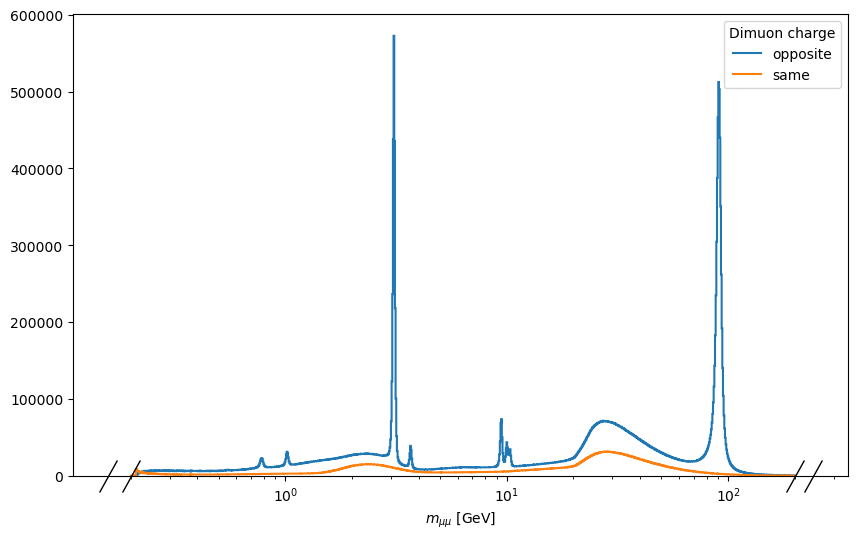

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
out["DoubleMuon"]["DoubleMuon"]["mass"].plot1d(ax=ax)
ax.set_xscale("log")
ax.legend(title="Dimuon charge")

# Getting fancy

Let's flesh out this analysis into a 4-muon analysis, searching for diboson events:

In [10]:
from collections import defaultdict
import numba


@numba.njit
def find_4lep_kernel(events_leptons, builder):
    """Search for valid 4-lepton combinations from an array of events * leptons {charge, ...}
    
    A valid candidate has two pairs of leptons that each have balanced charge
    Outputs an array of events * candidates {indices 0..3} corresponding to all valid
    permutations of all valid combinations of unique leptons in each event
    (omitting permutations of the pairs)
    """
    for leptons in events_leptons:
        builder.begin_list()
        nlep = len(leptons)
        for i0 in range(nlep):
            for i1 in range(i0 + 1, nlep):
                if leptons[i0].charge + leptons[i1].charge != 0:
                    continue
                for i2 in range(nlep):
                    for i3 in range(i2 + 1, nlep):
                        if len({i0, i1, i2, i3}) < 4:
                            continue
                        if leptons[i2].charge + leptons[i3].charge != 0:
                            continue
                        builder.begin_tuple(4)
                        builder.index(0).integer(i0)
                        builder.index(1).integer(i1)
                        builder.index(2).integer(i2)
                        builder.index(3).integer(i3)
                        builder.end_tuple()
        builder.end_list()

    return builder


def find_4lep(events_leptons):
    if ak.backend(events_leptons) == "typetracer":
        # here we fake the output of find_4lep_kernel since
        # operating on length-zero data returns the wrong layout!
        ak.typetracer.length_zero_if_typetracer(events_leptons.charge) # force touching of the necessary data
        return ak.Array(ak.Array([[(0,0,0,0)]]).layout.to_typetracer(forget_length=True))
    return find_4lep_kernel(events_leptons, ak.ArrayBuilder()).snapshot()


class FancyDimuonProcessor(processor.ProcessorABC):
    def process(self, events):
        dataset_axis = hist.axis.StrCategory([], growth=True, name="dataset", label="Primary dataset")
        mass_axis = hist.axis.Regular(300, 0, 300, name="mass", label=r"$m_{\mu\mu}$ [GeV]")
        pt_axis = hist.axis.Regular(300, 0, 300, name="pt", label=r"$p_{T,\mu}$ [GeV]")
        
        h_nMuons = hda.Hist(
            dataset_axis,
            hda.hist.hist.axis.IntCategory(range(6), name="nMuons", label="Number of good muons"),
            storage="weight", label="Counts",
        )
        h_m4mu = hda.hist.Hist(dataset_axis, mass_axis, storage="weight", label="Counts")
        h_mZ1 = hda.hist.Hist(dataset_axis, mass_axis, storage="weight", label="Counts")
        h_mZ2 = hda.hist.Hist(dataset_axis, mass_axis, storage="weight", label="Counts")
        h_ptZ1mu1 = hda.hist.Hist(dataset_axis, pt_axis, storage="weight", label="Counts")
        h_ptZ1mu2 = hda.hist.Hist(dataset_axis, pt_axis, storage="weight", label="Counts")
                
        cutflow = defaultdict(int)
        
        dataset = events.metadata['dataset']
        muons = ak.zip({
            "pt": events.Muon_pt,
            "eta": events.Muon_eta,
            "phi": events.Muon_phi,
            "mass": events.Muon_mass,
            "charge": events.Muon_charge,
            "isolation": events.Muon_pfRelIso03_all,
        }, with_name="PtEtaPhiMCandidate", behavior=candidate.behavior)
        
        # make sure they are sorted by transverse momentum
        muons = muons[ak.argsort(muons.pt, axis=1)]
        
        cutflow['all events'] = ak.num(muons, axis=0)
        
        # impose some quality and minimum pt cuts on the muons
        muons = muons[
            (muons.pt > 5)
            & (muons.isolation < 0.2)
        ]
        cutflow['at least 4 good muons'] += ak.sum(ak.num(muons) >= 4)
        h_nMuons.fill(dataset=dataset, nMuons=ak.num(muons))
        
        # reduce first axis: skip events without enough muons
        muons = muons[ak.num(muons) >= 4]
        
        # find all candidates with helper function
        fourmuon = dak.map_partitions(find_4lep, muons)
        fourmuon = [muons[fourmuon[idx]] for idx in "0123"]

        fourmuon = ak.zip({
            "z1": ak.zip({
                "lep1": fourmuon[0],
                "lep2": fourmuon[1],
                "p4": fourmuon[0] + fourmuon[1],
            }),
            "z2": ak.zip({
                "lep1": fourmuon[2],
                "lep2": fourmuon[3],
                "p4": fourmuon[2] + fourmuon[3],
            }),
        })

        cutflow['at least one candidate'] += ak.sum(ak.num(fourmuon) > 0)

        # require minimum dimuon mass
        fourmuon = fourmuon[(fourmuon.z1.p4.mass > 60.) & (fourmuon.z2.p4.mass > 20.)]
        cutflow['minimum dimuon mass'] += ak.sum(ak.num(fourmuon) > 0)

        # choose permutation with z1 mass closest to nominal Z boson mass
        bestz1 = ak.singletons(ak.argmin(abs(fourmuon.z1.p4.mass - 91.1876), axis=1))
        fourmuon = ak.flatten(fourmuon[bestz1])

        h_m4mu.fill(
            dataset=dataset,
            mass=(fourmuon.z1.p4 + fourmuon.z2.p4).mass,
        )
        h_mZ1.fill(
            dataset=dataset, 
            mass=fourmuon.z1.p4.mass,
        )
        h_mZ2.fill(
            dataset=dataset, 
            mass=fourmuon.z2.p4.mass,
        )
        h_ptZ1mu1.fill(
            dataset=dataset,
            pt=fourmuon.z1.lep1.pt,
        )
        h_ptZ1mu2.fill(
            dataset=dataset,
            pt=fourmuon.z1.lep2.pt,
        )
        return {
            'nMuons': h_nMuons,
            'mass': h_m4mu,
            'mass_z1': h_mZ1,
            'mass_z2': h_mZ2,
            'pt_z1_mu1': h_ptZ1mu1,
            'pt_z1_mu2': h_ptZ1mu2,
            'cutflow': {dataset: cutflow},
        }

    def postprocess(self, accumulator):
        pass

In [11]:
import time

tstart = time.time()

to_compute = apply_to_fileset(
                FancyDimuonProcessor(),
                max_chunks(dataset_runnable, 300),
                schemaclass=BaseSchema,
            )
elapsed = time.time() - tstart
print(elapsed)

0.11320662498474121


In [12]:
(out,) = dask.compute(to_compute, scheduler='threads')
print(out)

/home/mukund/miniconda3/envs/coffeaenv/lib/python3.12/site-packages/dask/base.py:1481: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/home/mukund/miniconda3/envs/coffeaenv/lib/python3.12/site-packages/awkward/_nplikes/array_module.py:245: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))


{'DoubleMuon': {'nMuons': Hist(
  StrCategory(['DoubleMuon'], growth=True, name='dataset', label='Primary dataset'),
  IntCategory([0, 1, 2, 3, 4, 5], name='nMuons', label='Number of good muons'),
  storage=Weight()) # Sum: WeightedSum(value=6.59744e+07, variance=6.59744e+07) (WeightedSum(value=6.61289e+07, variance=6.61289e+07) with flow), 'mass': Hist(
  StrCategory(['DoubleMuon'], growth=True, name='dataset', label='Primary dataset'),
  Regular(300, 0, 300, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
  storage=Weight()) # Sum: WeightedSum(value=64891, variance=64891) (WeightedSum(value=72889, variance=72889) with flow), 'mass_z1': Hist(
  StrCategory(['DoubleMuon'], growth=True, name='dataset', label='Primary dataset'),
  Regular(300, 0, 300, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
  storage=Weight()) # Sum: WeightedSum(value=72373, variance=72373) (WeightedSum(value=72889, variance=72889) with flow), 'mass_z2': Hist(
  StrCategory(['DoubleMuon'], growth=True, name='dataset', la

In [13]:
nevt = out['ZZ to 4mu']['cutflow']['ZZ to 4mu']['all events'] + out['DoubleMuon']['cutflow']['DoubleMuon']['all events']
print("Events/s:", (nevt / elapsed).compute(scheduler='threads'))

/home/mukund/miniconda3/envs/coffeaenv/lib/python3.12/site-packages/dask/base.py:1481: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


Events/s: 597384949.9454238


What follows is just us looking at the output, you can execute it if you wish

In [14]:
# scale ZZ simulation to expected yield
lumi = 11.6  # 1/fb
zzxs = 7200 * 0.0336**2  # approximate 8 TeV ZZ(4mu)
nzz = out['ZZ to 4mu']['cutflow']['ZZ to 4mu']['all events']

scaled = {}
for (name1, h1), (nam2, h2) in zip(out['ZZ to 4mu'].items(), out['DoubleMuon'].items()):
    if isinstance(h1, hist.Hist) and isinstance(h2, hist.Hist):
        scaled[name1] = h1.copy() + h2.copy()
        scaled[name1].view()[0, :] *= lumi * zzxs / nzz.compute()

(1, 64998708.06719517)

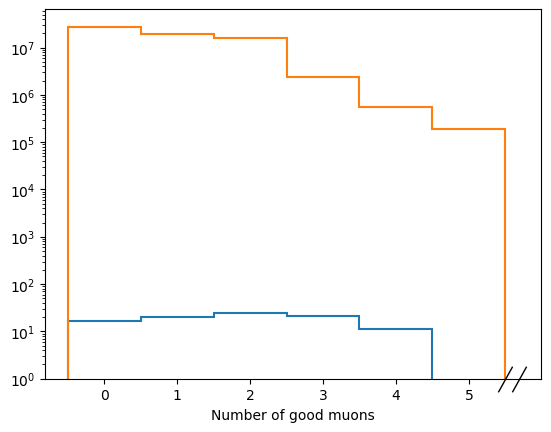

In [15]:
fig, ax = plt.subplots()
scaled['nMuons'].plot1d(ax=ax, overlay='dataset')
ax.set_yscale('log')
ax.set_ylim(1, None)

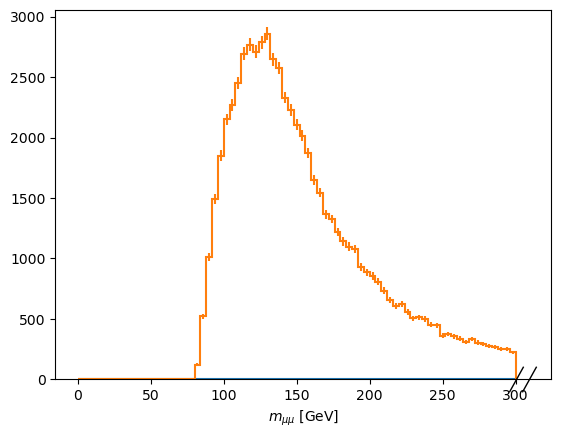

In [16]:
fig, ax = plt.subplots()

scaled['mass'][:, ::hist.rebin(4)].plot1d(ax=ax, overlay='dataset');

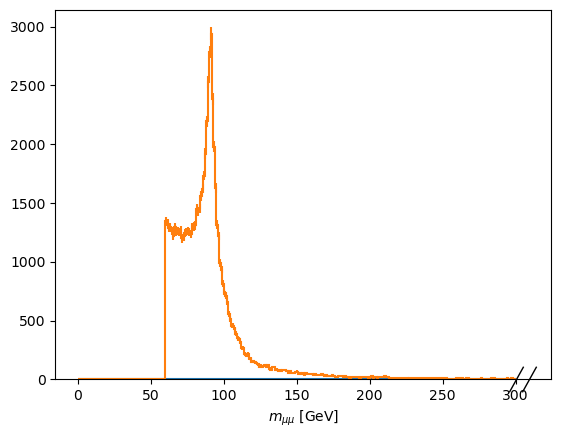

In [17]:
fig, ax = plt.subplots()

scaled['mass_z1'].plot1d(ax=ax, overlay='dataset');

(2.0, 300.0)

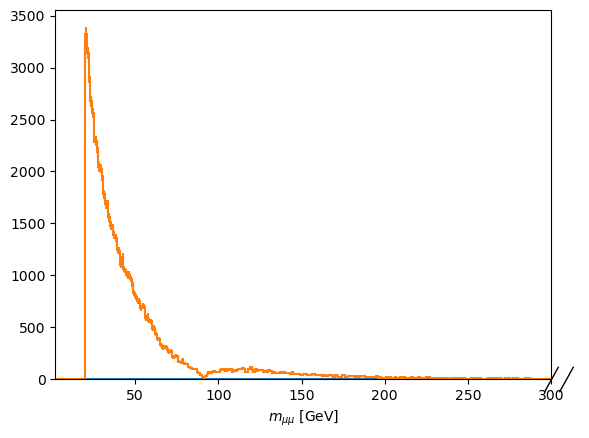

In [18]:
fig, ax = plt.subplots()

scaled['mass_z2'].plot1d(ax=ax, overlay='dataset')
ax.set_xlim(2, 300)

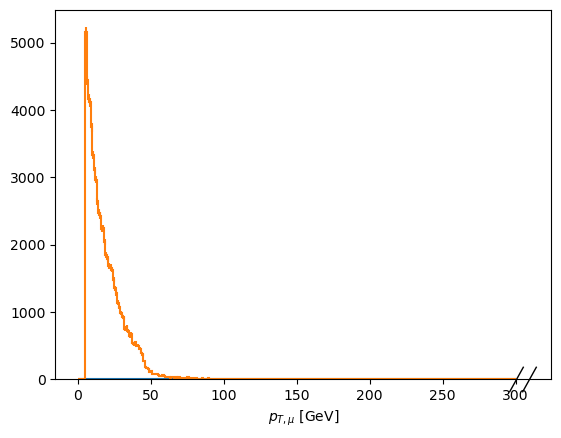

In [25]:
fig, ax = plt.subplots()

scaled['pt_z1_mu1'].plot1d(ax=ax, overlay='dataset');

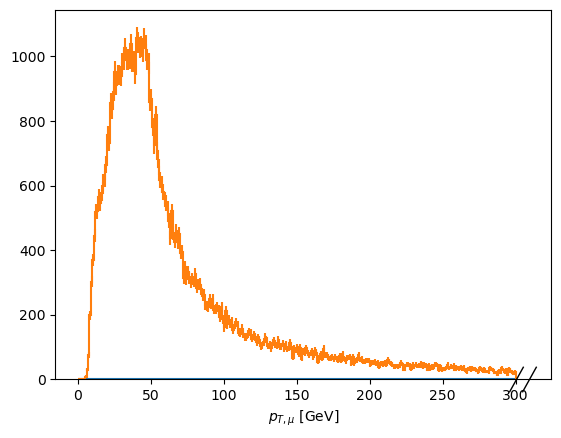

In [19]:
fig, ax = plt.subplots()

scaled['pt_z1_mu2'].plot1d(ax=ax, overlay='dataset');